# CSE2530 Computational Intelligence
## Assignment 2: Ant Colony Optimization and Genetic Algorithms

<div style="background-color:#f1be3e">

_Fill in your group number **from Brightspace**, names, and student numbers._
    
|    Group   |           25          |
|------------|----------------------|
| Jannes Kelso  |        5531543       |
| Antonio Lupu  |        5677211       |
| Eve Smura  |        5815592       |
| Maria Cristescu  |        5704502       |

#### Imports

In [1]:
"""
You may only use numpy to implement your algorithms
You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.
Put all of your imports in this code block.
"""
import numpy as np
import random
import sys
import time
import copy
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

"""
The following classes are fully implemented in their own files and you should not change them.
Nonetheless, we encourage you to check how they work; this will help you get started.
"""
from Coordinate import Coordinate
from Direction import Direction
from PathSpecification import PathSpecification
from Route import Route
from SurroundingPheromone import SurroundingPheromone
from TSPData import TSPData
from Visualizer import Visualizer

np.random.seed = 42

## Part 1: The Travelling Robot Problem
### 1.1 Problem Analysis
#### Question 1:

<div style="background-color:#f1be3e">

The travelling salesman problem is quite simply defined as the problem of finding the shortest path that visits a set of locations and then returns to the start. That is to say we are given n nodes, and for each pair of nodes a distance d. We search for a closed path the visites each node using while costing the least. The cost is the sum of the distances that were traveresed between the nodes. 

References:
 - https://www.sciencedirect.com/topics/computer-science/traveling-salesman-problem#chapters-articles
 - https://graphics.stanford.edu/courses/cs468-06-winter/Papers/arora-tsp.pdf

#### Question 2

<div style="background-color:#f1be3e">

In our problem we also work on a graph of nodes, which is complete and symmetric. However, In the classic TSP we try to return back to the starting location, whereas in this case our final destination is different from the starting node. We specify a specific point to end at, which is distinct from the products we must visit, adding an extra node to the graph which increases the complexity of the problem. 

#### Question 3

<div style="background-color:#f1be3e">

CI techniques are particularly applicable to the TSP, in particular evolutional systems, as they allow for efficient approximations of solutions. Approaches to find optimal solutions are incredibly computationally intensive and quickly become unfeasible with larger graphs. Close approximations allow for higher practicality in terms of quicker runtimes. CI techniques are also very useful because given decent hyperparameters they will optimize the solutions automatically with no human assistance. How optimal of a solution we are looking for can then be balanced in accordance with how much time and compute we are willing to put behind a given algorithm.

### 1.2 Genetic Algorithm

In [2]:
optimal_tsp = TSPData.read_from_file("../data/optimal_tsp")
product_list = np.arange(len(optimal_tsp.product_locations))

In [3]:
class Chromosome:
    def __init__(self, product_list, gene_dict=None):
        self.product_list = product_list
        
        # Randomly initialize genes if none are provided
        if gene_dict == None:
            # self.gene_dict: order (key) -> product (value)
            self.gene_dict = {}
            
            # Create random order of products
            randomized_product_list = np.random.choice(product_list,len(product_list),replace=False)
            
            # Set genes to have products in thei random order
            for product, order in zip(randomized_product_list, np.arange(len(product_list))):
                self.gene_dict[order] = product
                
        # Set genes to dictionary if one is provided
        else:
            self.gene_dict = gene_dict
    
    # Returns product id's according to the order they are visited in
    def get_products_in_order(self):
        return list(self.gene_dict.values())
    
    # Returns order of a specified product
    def get_order_by_product(self, product):
        return list(self.gene_dict.keys())[list(self.gene_dict.values()).index(product)]
    
    # Returns product of a specified order
    def get_product_by_order(self, order):
        return self.gene_dict[order]
    
    # To string value
    def __str__(self):
        ret = "Chromosome:\n\tOrder:"
        for order in list(self.gene_dict.keys()):
            ret += f" [{order}]"
        ret += "\n\tProd: "
        for product in list(self.gene_dict.values()):
            ret += f" [{product}]"
        return ret

In [4]:
class Fitness:
    def __init__(self, tsp_data, exponential_scaling):
        self.tsp_data = tsp_data
        self.exponential_scaling = exponential_scaling
        
    # Compute the fitenss of a list of chromosomes
    # Fitness is computed as the total distance a path traverses
    def get_fitness_list(self, chromosome_list):
        fitnesses = []
        
        for chromosome in chromosome_list:
            cost = 0
            products = chromosome.get_products_in_order()
            
            # Add cost from start to first product
            cost += self.tsp_data.get_start_distances()[products[0]]
            
            # Add cost for each trip from product to product
            prev_product = products[0]
            for next_product in products[1:]:
                cost += self.tsp_data.get_distances()[prev_product][next_product]
                prev_product = next_product
        
            # Add cost from last product to end
            cost += self.tsp_data.get_end_distances()[prev_product] + len(self.tsp_data.product_locations)
            
            # Add fitness at index equal to its order
            fitnesses.append(cost)

        return fitnesses
    
    # Gets adjusted fitness ratio of each chromosome
    def get_fitness_ratio_list(self, fitness_list):
        # Avoids division by 0
        if (len(fitness_list) == 1): 
            return [1.0]
        
        if self.exponential_scaling != None:
            fitness_list = self.scale_linearly(fitness_list)
            fitness_list = self.scale_exponentially(fitness_list)
        fitness_list = self.inverse_ratio(fitness_list)
        fitness_ratio_list = self.normalize_probabilities(fitness_list)
            
        return fitness_ratio_list
    
    # Scale the fitness down linearly to bring values in a range 
    # where exponentiation is feasible and the values stay in the same neighbourhood
    def scale_linearly(self, fitness_list):
        epsilon = np.nextafter(0, 1)
        
        # If goes change back to dynamic max in and min in
        min_in, max_in = self.get_max_and_min()
        min_out = 0
        max_out = np.min([1, np.max([0.01, (max_in - min_in) / (max_in + min_in)])]) + 1
        
        slope = (max_out - min_out) / (max_in - min_in + epsilon)

        # Map each value to new range
        return [min_out + slope * (fitness - min_in) for fitness in fitness_list]

    # Scale the fitness exponentially
    def scale_exponentially(self, fitness_list):
        return [(np.e ** (self.exponential_scaling * fitness)) - 1 for fitness in fitness_list]
    
    # Finds (1 - percent of total fitness a chromosome is reponsible for)
    # Finding inverse makes the fitness ration higher for low fitness scores
    # This means we minimize the fitness function instead of maximizing it
    def inverse_ratio(self, fitness_list):
        ratios_unnormalized = []
        total_fitness = np.sum(fitness_list)
        for fitness in fitness_list:
            ratios_unnormalized.append((np.max(fitness_list) / total_fitness) * 1.001 - (fitness / total_fitness))
            
        return ratios_unnormalized
    
    # Normalize the ratios to add up to 1
    def normalize_probabilities(self, fitness_list):
        total_ratios_unnormalized = np.sum(fitness_list)
        ratios_normalized = []
        for ratio in fitness_list:
            ratios_normalized.append(ratio / total_ratios_unnormalized)
        return ratios_normalized
    
    # Find upper bound on theoretical minimum and maximum path length
    # by finding shortest and longest connection between two places
    # and then multiplying each by the total number of steps to take
    def get_max_and_min(self):
        inter_product_distances = np.array(self.tsp_data.get_distances()).flatten()
        inter_product_distances = inter_product_distances[inter_product_distances != 0]
        
        start_distances = np.array(self.tsp_data.get_start_distances()).flatten()
        start_distances = start_distances[start_distances != 0]
        
        end_distances = np.array(self.tsp_data.get_end_distances()).flatten()
        end_distances = end_distances[end_distances != 0]
        
        min_distance = np.min([np.min(inter_product_distances),np.min(start_distances),np.min(end_distances)])
        max_distance = np.max([np.max(inter_product_distances),np.max(start_distances),np.max(end_distances)])
        
        num_steps = len(self.tsp_data.product_locations) + 1
        min_path = num_steps * min_distance
        max_path = num_steps * max_distance
        
        return min_path, max_path
    
    def get_fitness_ratio_list_v2(self, fitness_list):        
        inverted_fitness_list = [1 / fitness for fitness in fitness_list]
        sum_inverted_finess_list = np.sum(inverted_fitness_list)
        fitness_ratio_list = [fitness / sum_inverted_finess_list for fitness in inverted_fitness_list]
            
        return fitness_ratio_list

In [5]:
def get_indices(lst, element):
    return [i for i in range(len(lst)) if lst[i] == element]

In [6]:
# Switch the order of two products adjacent in order
def mutate_chromosome_adjacent(chromosome):
    # Get 2 random genes that are next to eachother by in order
    order_1 = np.random.choice(np.arange(len(chromosome.product_list)))
    order_2 = np.random.choice([max(0,order_1 - 1), min(len(chromosome.product_list)-1, order_1 + 1)])
    
    # Switch order
    saved_order_1_product = chromosome.gene_dict[order_1]
    chromosome.gene_dict[order_1] = chromosome.gene_dict[order_2]
    chromosome.gene_dict[order_2] = saved_order_1_product
    
    return chromosome

In [7]:
# Switch the order of two random products
def mutate_chromosome(chromosome):
    # Get 2 random genes that are next to eachother by in order
    order_1, order_2 = np.random.choice(np.arange(len(chromosome.product_list)), 2, replace=False)
    
    # Switch order
    saved_order_1_product = chromosome.gene_dict[order_1]
    chromosome.gene_dict[order_1] = chromosome.gene_dict[order_2]
    chromosome.gene_dict[order_2] = saved_order_1_product
    
    return chromosome

In [8]:
def cross_over_chromosomes(chromosome_1, chromosome_2):
    # Sums the order number for each product. So the order number for prod 1 in both chromosomes is added
    # Dict: product -> sum of order
    summed_dict = {}
    c1_product_list = chromosome_1.get_products_in_order()
    c2_product_list = chromosome_2.get_products_in_order()
    
    # Sums orders by product and adds result to dict by product
    for product in chromosome_1.product_list:
        summed_dict[product] = c1_product_list.index(product) + c2_product_list.index(product)
        
    # Sorts the dict by sum ascending
    summed_dict = dict(sorted(summed_dict.items(),key=lambda x:x[1]))
    
    products = list(summed_dict.keys())
    sums = list(summed_dict.values())
    
    # Rebuild new chromosome
    new_gene_dict = {}
    order = 0
    while order < len(c1_product_list):        
        smallest_summed_order = sums[0]
        duplicate_sums_indices = get_indices(sums, smallest_summed_order)
        
        # No duplicate sums, so which product comes next is clear
        if (len(duplicate_sums_indices) == 1):
            # Add product with lowest sum as the next in order
            new_gene_dict[order] = products[0]
            # Remove product and sum for next iteration
            products.remove(products[0])
            sums.remove(smallest_summed_order)
            order += 1
            continue
        
        # In the case that there are duplicate sums we order by the preferred order of chromosome 1 as it had better fittness
        # Dict: product -> order
        tie_breaker_dict = {}
        for product in [products[i] for i in duplicate_sums_indices]:
            tie_breaker_dict[product] = chromosome_1.get_order_by_product(product)
        
        # Sort the tie breaker dict by the order ascending
        tie_breaker_dict_sorted = dict(sorted(tie_breaker_dict.items(),key=lambda x:x[1]))
        
        # Add products to visit in that order and remove them from products and sums for next iter
        for product in list(tie_breaker_dict_sorted.keys()):
            new_gene_dict[order] = product
            products.remove(product)
            sums.remove(sums[0])
            order += 1
    
    return Chromosome(list(new_gene_dict.values()), dict(sorted(new_gene_dict.items())))

In [9]:
def cross_over_chromosomes_v2(chromosome_1, chromosome_2):
    num_products = len(chromosome_1.product_list)
    
    start_order = np.random.choice(np.arange(0, int((num_products + 1) / 2)))
    end_order = int(start_order + (num_products + 1) / 2)
    
    if start_order > end_order:
        temp = start_order
        start_order = end_order
        end_order = temp

    c1_products = c1.get_products_in_order()
    c2_products = c2.get_products_in_order()
    
    c1_order_range = range(start_order, end_order + 1)
    c2_order_range = list(set(range(len(chromosome_1.product_list))) - set(c1_order_range))
        
    new_gene_dict = {}
    
    for order in c1_order_range:
        new_gene_dict[order] = c1_products[order]
        c2_products.remove(c1_products[order])
    
    for order, product in zip(c2_order_range, c2_products):
        new_gene_dict[order] = product
    
#     print(chromosome_1.get_products_in_order())
#     print(chromosome_2.get_products_in_order())
#     print(start_order, end_order)
    return Chromosome(list(new_gene_dict.values()), dict(sorted(new_gene_dict.items())))

In [10]:
# TSP problem solver using genetic algorithms.
class GeneticAlgorithm:

    """
    Constructs a new 'genetic algorithm' object.
    @param generations: the amount of generations.
    @param pop_size: the population size.
    """
    def __init__(self, generations, pop_size, cross_over_prob, mutation_prob, exponential_scaling=0.5, elite_percent=0.1, fitness_threshold=0, cross_over_summing=True):
        self.generations = generations
        self.pop_size = pop_size
        self.cross_over_prob = cross_over_prob
        self.mutation_prob = mutation_prob
        self.exponential_scaling = exponential_scaling
        self.elite_percent = elite_percent
        self.average_fitness_list = None
        self.best_fitness_list = None
        self.fitness_threshold = fitness_threshold
        self.cross_over_summing = cross_over_summing
        self.current_generation = 0
        
    """
    This method should solve the TSP.
    @param tsp_data: the data describing the problem.
    @return the optimized product sequence.
    """
    def solve_tsp(self, tsp_data):
        product_list = np.arange(0, len(tsp_data.product_locations))
        num_products = len(product_list)
        chromosome_list = [Chromosome(product_list) for i in range(self.pop_size)]
        fitness = Fitness(tsp_data, self.exponential_scaling)
        
        # Maintain logs of average and best performing chromosome fitness
        self.average_fitness_list = []
        self.best_fitness_list = []
        last_fitness = sys.maxsize
        
        # Iterate until max generations met or threshold value met
        self.current_generation = 0
        while self.current_generation < self.generations and last_fitness > self.fitness_threshold:
            # Calculate fitnesses and fitness ratios
            fitness_list = fitness.get_fitness_list(chromosome_list)
            fitness_ratio_list = fitness.get_fitness_ratio_list(fitness_list)
            
            # Add avg and best to list
            self.average_fitness_list.append(np.mean(fitness_list))
            self.best_fitness_list.append(np.min(fitness_list))
            last_fitness = self.best_fitness_list[-1]
            
#             print(f"\n----------------------------------------------------\n\nGeneration:\t{self.current_generation}\tTop Path:{last_fitness}")
#             print(f"Fitness:\t{fitness_list}")
#             print(f"Fitness Ratio:\t{np.array(fitness_ratio_list).round(3)}")
            
            # Save the top 10% of chromosomes from current generation to reintroduce in next generation
            if self.elite_percent == 0:
                num_elites = 0
                elite_chromosome_list = []
            else:
                num_elites = np.max([1,int(self.pop_size * self.elite_percent)])
                elite_chromosome_list = copy.deepcopy(np.array(chromosome_list)[np.argsort(fitness_list)[:num_elites]])
            
            # Cross over chromosomes
            child_chromosome_list = self.get_child_chromosome_list(chromosome_list, fitness_ratio_list)
            
            # Mutate chromosomes
            chromosome_list = self.get_mutated_chromosome_list(child_chromosome_list)
            
            # Reintroduce elites
            for index, elite_chromosome in enumerate(elite_chromosome_list):
                chromosome_list[index] = elite_chromosome

            self.current_generation += 1
        
        # Add final iteration to tracking lists
        self.average_fitness_list.append(np.mean(fitness_list))
        self.best_fitness_list.append(np.min(fitness_list))
        last_fitness = self.best_fitness_list[-1]
        
        # Select most fit solution
        index_fittest_chromosome = np.argmin(fitness.get_fitness_list(chromosome_list))
        solution = chromosome_list[index_fittest_chromosome].get_products_in_order()
        
        print(f"Selected Path: {solution}")
        return solution
        
    """
    This method clones and crosses over subsets of the input list. Which parents are selected is randomized by the fitness ratio
    @param chromosome_list: list of chromosomes to clone or crossover
    @param fitness_ratio_list: probabilites to pick any chromosome for crossing over
    @return list of chromosomes
    """
    def get_child_chromosome_list(self, chromosome_list, fitness_ratio_list):
        # Generate lists for each new chromosome to be created with whether they are cross over or clone
        cross_over_list = np.random.choice(a=[True,False], size=self.pop_size, p=[self.cross_over_prob, 1 - self.cross_over_prob])
        child_chromosome_list = []
        
        for chromosome, cross_over in zip(chromosome_list, cross_over_list):
            # Pick 2 random chromosomes according to fitness ratios as probabilites
            chromosome_1, chromosome_2 = np.random.choice(a=chromosome_list, size=2, replace=False, p=fitness_ratio_list)
            
            # Clones chromosome and goes to next iter
            if not cross_over:
                child_chromosome_list.append(chromosome_1)
                continue
            
            # Set chromosome_1 to whichever had higher fitness_ratio
            chromosome_1_ratio = fitness_ratio_list[chromosome_list.index(chromosome_1)]
            chromosome_2_ratio = fitness_ratio_list[chromosome_list.index(chromosome_2)]
            if (chromosome_1_ratio < chromosome_2_ratio):
                chromosome_1_temp = chromosome_1
                chromosome_1 = chromosome_2
                chromosome_2 = chromosome_1_temp
            
            # Get child of chromosomes and append it
            if self.cross_over_summing:
                child_chromosome_list.append(cross_over_chromosomes(chromosome_1, chromosome_2))
            else:
                child_chromosome_list.append(cross_over_chromosomes_v2(chromosome_1, chromosome_2))
            
        return child_chromosome_list
        
    """
    This method mutates (or doesn't) an entire list
    @param chromosome_list: list of chromosomes to clone or crossover
    @return list of chromosomes
    """
    def get_mutated_chromosome_list(self, chromosome_list):
        # Generate lists for each new chromosome to be created with whether they are mutated or not
        mutation_list = np.random.choice(a=[True,False], size=self.pop_size, p=[self.mutation_prob, 1 - self.mutation_prob])
        mutated_chromosome_list = []
        
        for chromosome, mutates in zip(chromosome_list, mutation_list):
            # Doesn't mutate, just keep chromosome as is and goes to next iter
            if not mutates: 
                mutated_chromosome_list.append(chromosome)
                continue
            
            # Mutates chromosome and goes to next iter
            mutated_chromosome_list.append(mutate_chromosome(chromosome))  
            
        return mutated_chromosome_list
                

#### Question 4

<div style="background-color:#f1be3e">

The genes represent a pairing of a product and an order. The order in this case is the index of the product in a path. The chromosomes are made up of as many genes as there are products. Each order is assigned with exactly one product and vice versa. We ensure that all operations on chromosomes and creations of chromosomes maintain this property, so that all chromosomes are valid path representations. This allows for a chromosome to represent a path through the maze, with the first product we visit given by the product in the chromosome with order equal to 1. 

#### Question 5

<div style="background-color:#f1be3e">

The fitness function will quite simply take a chromosome, convert it to a path, and then return the total length of this path. This means that, in contrast to the exampels from the slides, we will be minimizing our fitness function in order to find the shortest path possible. 

This means that we need to create find the fitness ratios in a different manner than the slides, otherwise we will maximize the fitness. At a base level this means we find the inverse chromosome impact on the total fitness of a population and scale the fitness ratio proportionally to that. This will mean that chromosomes with smaller fitnesses are assigned a larger fitness ratio. Initially we used the fitness ratio function (1 / fitness) / ( sum ( 1 / fitness)). However, we noticed that when dealing with rather large fintesses and semi-large populations the fitness of most chromosomes was quite similiar, even when one had a clearly better fitness than the other.
    
For example:  
fitnesses - [3800, 4900, 4200, 4000, 4500, 3800, 4100, 4900, 4200, 2800, 3100, 2800]  
ratios - [0.083, 0.065, 0.075, 0.079, 0.07 , 0.083, 0.077, 0.065, 0.075,
       0.113, 0.102, 0.113]  
As you can see a chromsome with fitness 3800 has a fitness ratio of 8.3% and a chromosome with fitness 2800 has 11.3%. These probabilites are too low and make the convergence of the algorithm extremely slow. This becomes even worse with larger populations. For these reasons we decided to scale the ratios exponentially so that smaller fitnesses have disproportionate fitness ratios. We scale the fitnesses down linearly to a small number, then exponentiatew them, then invert them, and finally normalize them. With the same fitnesses, our alogrithm gives these results:  
ratios - [0.095, 0 , 0.062, 0.079, 0.036, 0.095, 0.07 , 0 , 0.062,
       0.174, 0.151, 0.174]  
These numbers are much nicer and have shown much quicker convergence. Importantly, imperfect chromosomes still have a decent chance of being selected however not nearly as much as clearly better solutions.

#### Question 6

<div style="background-color:#f1be3e">

Parents are selected randomly, with the likelihood of each chromosome being equal to their fitness ratio. Two parents cannot be the same chromosome.

#### Question 7

<div style="background-color:#f1be3e">

Cross over: We have implemented cross overs in an unusual way. We sum the order of each product and the sort the products by the sum in ascending order. Ties of sums are broken by the fitter chromosome. This way we take a sore of "average" of both parents. This is the main driving factor behind the evolution of the chromosomes. We take two chromosomes (with higher likelihood of selecting fitter ones) and find an average of both. If the solution is worse it's not so likely it will survive the following generation. However there is also a good chance that the combination takes good elements from both chromosomes and creates an even better child.
    
Mutation: We mutate chromosomes by switching the order of two random products. Usually this will be detrimental, but sometimes it will find an improvement that crossing over wouldnt have found. The function of mutations are to avoid getting stuck in local minima as will be described below.

#### Question 8

<div style="background-color:#f1be3e">

With cross over alone, it is possible for the algorithm to get into a state where one "race" of chromosomes has taken over, so that they are all more or less identical. From here, crossing over chromosomes will only create more of the same, which isn't useful towards evolution. If it is the global minima there is clearly no escape, however if it is local we escape by randomly mutating some chromosomes. Usually mutations will not be very useful, but every now and then they will find a better path, which crossing over couldn't have found. This helps us continue improving after the fitness plateaus, and is usually followed by most chromosomes crossing over with this new chromosome or it simply being cloned. We enter a new minima eventually and the cycle starts anew.

#### Question 9

<div style="background-color:#f1be3e">

Elitism is the practice of giving the top x% chromosomes with highest fitness preferential treatment. This can mean hardcoding that they will cross over at least once and/or cloning them at least once. This ensures that good chromosomes aren't lost due to unlucky selections and makes it inevitable that good solutions will have an impact on the population. Even if they are basically ignored during a given generation, they will at some point be selected. We have implemented elitism with cloning, so that the top x% are always cloned into the chromosome pool of the next generation.

#### Question 10

In [11]:
# Please keep your parameters for the Genetic Algorithm easily changeable here
population_size = 64
cross_over_prob = 0.4
mutation_prob = 0.6
exponential_scaling = 1
elite_percent = 0.1
cross_over_summing = True

generations = 3000
fitness_threshold = 1343
persist_file = "./../data/optimal_tsp"

# Setup optimization
tsp_data = TSPData.read_from_file(persist_file)
ga = GeneticAlgorithm(generations, population_size, cross_over_prob, mutation_prob, exponential_scaling, elite_percent, fitness_threshold, cross_over_summing)

# # Run optimzation and write to file
solution = ga.solve_tsp(tsp_data)
tsp_data.write_action_file(solution, "./../data/tsp_solution.txt")

Selected Path: [0, 1, 6, 4, 13, 15, 3, 8, 7, 17, 9, 14, 11, 12, 5, 10, 2, 16]


In [15]:
iterations = 20

population_size = [16,32,64,128]
generations = [3000]
cross_over_prob = [0.2,0.4,0.6,0.8]
mutation_prob = [0.01,0.1,0.3,0.6,0.08]
exponential_scaling = [1]
elite_percent = [0.1]
cross_over_summing = [True]
fitness_threshold = 1343
persist_file = "./../data/optimal_tsp"
tsp_data = TSPData.read_from_file(persist_file)

combinations = list(itertools.product(population_size, generations, cross_over_prob, mutation_prob, exponential_scaling, elite_percent, cross_over_summing))
total_combinations = len(combinations)

In [ ]:
# This takes quite a long time to run, 
# so if you would like to run the entire file again, 
# you should skip this cell

solution_fitness_list = []
num_generation_list = []
runtime_list = []

for index, combination in enumerate(combinations):
    population_size, generations, cross_over_prob, mutation_prob, exponential_scaling, elite_percent, cross_over_summing = combination
    print(f"[{index+1} / {total_combinations}]\tpopulation_size = {population_size}\tcross_over_prob = {cross_over_prob}\tmutation_prob = {mutation_prob}\telite_percent = {elite_percent}\tcross_over_summing = {cross_over_summing}")
    
    solution_fitness = 0
    num_generations = 0
    runtime = 0
    
    for iteration in range(iterations):
        start_time = time.time()
        
        ga = GeneticAlgorithm(generations, population_size, cross_over_prob, mutation_prob, exponential_scaling, elite_percent, fitness_threshold, cross_over_summing)
        ga.solve_tsp(tsp_data)
        
        solution_fitness += ga.best_fitness_list[-1] / iterations
        num_generations += ga.current_generation / iterations
        runtime += (time.time() - start_time) / iterations
    
    print(f"\tFitness: {solution_fitness}\tNum Generation: {num_generations}\tRuntime: {runtime}")
    solution_fitness_list.append(solution_fitness)
    num_generation_list.append(num_generations)
    runtime_list.append(runtime)
    
hyper_params = np.array(combinations)
hyper_param_results = np.array([solution_fitness_list, num_generation_list, runtime_list]).T
hyper_param_data = np.concatenate((hyper_param_results, hyper_params), axis=1)

df = pd.DataFrame(hyper_param_data, columns = ['Fitness', 'Generations', 'Runtime', 'population_size', 'generations', 'cross_over_prob', 'mutation_prob', 'exponential_scaling', 'elite_percent', 'cross_over_summing']) 
df = df.sort_values(["Fitness", "Runtime"])

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 15)
display(df)
    

In [17]:
df = pd.read_csv("./../data/hyper_param_data.csv")
df

,Index,Fitness,Generations,Runtime,population_size,generations,cross_over_prob,mutation_prob,exponential_scaling,elite_percent,cross_over_summing
0,48,1343.0,319.20,4.789496,64.0,3000.0,0.4,0.60,1.0,0.1,1.0
1,53,1343.0,313.95,4.949619,64.0,3000.0,0.6,0.60,1.0,0.1,1.0
2,73,1343.0,177.65,8.005506,128.0,3000.0,0.6,0.60,1.0,0.1,1.0
3,42,1343.0,721.00,9.965190,64.0,3000.0,0.2,0.30,1.0,0.1,1.0
4,78,1343.0,244.35,11.370948,128.0,3000.0,0.8,0.60,1.0,0.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
75,20,2017.1,2958.70,15.157675,32.0,3000.0,0.2,0.01,1.0,0.1,1.0
76,0,2026.0,2885.40,6.621348,16.0,3000.0,0.2,0.01,1.0,0.1,1.0
77,15,2060.7,3000.00,8.236505,16.0,3000.0,0.8,0.01,1.0,0.1,1.0
78,5,2087.5,3000.00,7.277337,16.0,3000.0,0.4,0.01,1.0,0.1,1.0


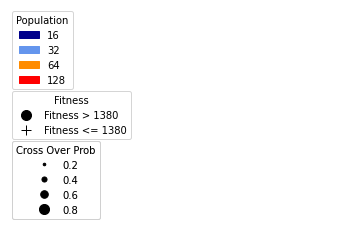

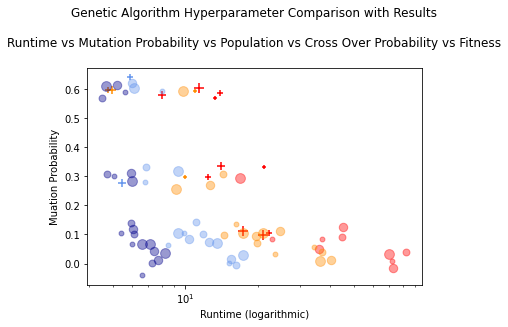

In [18]:
viable_fitness_models = df.loc[df['Fitness'] <= 5000]
num_data_points = len(viable_fitness_models.columns)

runtime_data = viable_fitness_models['Runtime'] 
population_data = viable_fitness_models['population_size']
cross_over_prob_data = viable_fitness_models['cross_over_prob']
mutation_prob_data = viable_fitness_models['mutation_prob']  + np.random.normal(0, 0.02, viable_fitness_models['mutation_prob'].size)
fitness_data =  viable_fitness_models['Fitness']

red_patch = mpatches.Patch(color='red', label='128')
orange_patch = mpatches.Patch(color='darkorange', label='64')
light_blue_patch = mpatches.Patch(color='cornflowerblue', label='32')
dark_blue_patch = mpatches.Patch(color='darkblue', label='16')
legend_population = plt.legend(handles=[dark_blue_patch,light_blue_patch,orange_patch,red_patch], title="Population", loc="upper left")

point_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=10, label='Fitness > 1380')
plus_line = mlines.Line2D([], [], color='black', marker='+', linestyle='None',markersize=10, label='Fitness <= 1380')
legend_fitness = plt.legend(handles=[point_line,plus_line], title="Fitness", loc="center left")

tiny_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=2.5, label='0.2')
small_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=5, label='0.4')
medium_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=7.5, label='0.6')
big_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=10, label='0.8')
legend_cross_over = plt.legend(handles=[tiny_line,small_line,medium_line,big_line], title="Cross Over Prob", loc="lower left")

plt.gca().add_artist(legend_population)
plt.gca().add_artist(legend_fitness)
plt.gca().add_artist(legend_cross_over)
plt.gca().set_axis_off()
plt.show()

for runtime, pop, cross, mutate, fit in zip(runtime_data, population_data, cross_over_prob_data, mutation_prob_data, fitness_data):
    x = runtime
    y = mutate
    size = cross * 120
    
    if pop == 16:
        color = "darkblue"
    if pop == 32:
        color = "cornflowerblue"
    if pop == 64:
        color = "darkorange"
    if pop == 128:
        color = "red"
    
    if fit <= 1380:
        alpha = 1
        marker = "+"
    else:
        alpha = 0.4
        marker = "o"
    
    plt.scatter(x, y, c=color,  marker=marker, s=size, alpha=alpha)
    
plt.xlabel('Runtime (logarithmic)')
plt.xscale("log");
plt.ylabel('Muation Probability')
plt.title('Genetic Algorithm Hyperparameter Comparison with Results\n\nRuntime vs Mutation Probability vs Population vs Cross Over Probability vs Fitness\n')
plt.show()

<div style="background-color:#f1be3e">

We trained models with 80 different sets of hyperparameters, covering all combinations of these values:  
population_size = [16,32,64,128]  
cross_over_prob = [0.2,0.4,0.6,0.8]  
mutation_prob = [0.01,0.1,0.3,0.6,0.08]  

We then ran each model 10 times and logged the average runtime and fitness the model achieved, in order to see how consistently the model performed. We did use early stopping when the optimal path of 1343 was achieved, so if the model did this the runtime is probably better. 

Take a moment to read the legends and make sense of the data above. For readability there is jitter added to the mutation probability and the runtime is scaled logarithmically to space data out more. We are searching for the hyperparameters that minimize runtime, while finding the optimal solution. This means + shaped data points at the left side of the graph. We can see that a mutation probaility of 0.6, population of 64, and cross over probability of 0.4 achieve the most optimal solution. This is closely followed by the same values except with a cross over probability of 0.6. The former will be the hyper parameters we will use from now on. 
    
There are also interesting patterns to be seen here. Larger populations lead to longer runtimes. Higher mutation probabilities put a cap on the runtimes. Larger populations are better at achieving optimal solutions. There are more insights to be gained in this graph.

<div style="background-color:#f1be3e">

We have achieved two optimal solutions with a fitness of 1343:  
[0, 1, 6, 4, 13, 15, 3, 8, 17, 7, 9, 14, 11, 12, 5, 10, 2, 16]   
[0, 1, 6, 4, 13, 15, 3, 8, 7, 17, 9, 14, 11, 12, 5, 10, 2, 16]
    
The solution seems optimal for several reasons. When we run the algorithm with various hyperparameters for many many generations we can see some models sharply decrease in fitness and quickly come to this solution within 200 generations, after which the solutions do not improve after 10000 more generations. Other models gradually work there way over 3000 generations to this solution, but are unable to surpass it after running for another 10000 generations. Inspecting these solution ins the Visualize tool we have been provided also reaffirms this solution, as it intuitively looks reasonable and there are no improvements I can identify. 

## Part 2: Path Finding Through Ant Colony Optimization
### 2.2 Observing the Problem

#### Question 11

<div style="background-color:#f1be3e">

The ACO is an optimization algorithm inspired by the foraging behaviour of ants. 

Ants release pheromones in their search for food, which other ants use to guide themselves. The more pheromones on a trail, the more chances there are for an ant to choose that specific trail. Each ant continues to release pheromones along the way, reinforcing the paths that lead to better solutions, while discouraging less favorable paths. 

Despite not always guaranteeing optimality, ACO is used for its ability to quickly find high-quality solutions to complex problems, especially in situations where finding exact optimal solutions is computationally infeasible due to the large search space or various computational constraints.

#### Question 12

<div style="background-color:#f1be3e">

Some expected topographical features we can expect in a maze that increase the difficulty of solving it are:
- Loops/ Dead ends
Loops and dead ends increase the likelihood of 'ants' to get stuck in a local optima, by taking the same loop multiple times before reaching the destination. To overcome these problems, we can introduce an pheromone evaporation constant, which would increase the possibility of ants to explore alternative routes

- Multiple paths to the finish line
If the maze has multiple paths to the finish line, then the ants can find one (non-optimal) path, and stop looking for a more efficeint one. To counter this issue, we can introduce a dynamic pheromone updating process, such that the ant can leave more pheromones on a path that seems promising, as opposed to a path that takes longer or doesn't reach the end of the maze.


#### Question 13

<div style="background-color:#f1be3e">

The formula of the amount of pheromones dropped by ants is:

$$
\tau_{ij} = (1 - \rho) \cdot \tau_{ij} + \sum_{k=1}^{N} \Delta\tau_{ij}^{(k)}
$$

Where:
- $\tau_{ij}$​ is the amount of pheromones on path $ij$ before the update.
- $\rho$ is the evaporation constant, representing the rate at which pheromones evaporate from the path.
- $N$ is the total number of ants.
- $\Delta\tau_{ij}^{(k)}$​ is the amount of pheromone deposited by ant $k$ on path $ij$ during the current iteration.



Ants need to drop pheromones in the maze to help other ants find the optimal path to the finish line. The more pheromones on a path, the more chances that ants will choose to go on that path, so pheromones reinforce the path that lead to better solutions, while discouraging the ones that don't.


#### Question 14

<div style="background-color:#f1be3e">

The equation for the evaporation is:

$$
\tau_{ij} = (1 - \rho) \cdot \tau_{ij} 
$$

Where:
- $\tau_{ij}$​ is the amount of pheromones on path $ij$ before the update.
- $\rho$ is the evaporation constant, representing the rate at which pheromones evaporate from the path.

The amount of pheromones evaporated on each iteration is determined by the evaporation constant. THe higher the constant, the faster the pheromones evaporate.

The purpose of the pheromones is to encourage the exploration of multiple paths. Since it introduces probabilities based on the amount of pheromones on each path, it helps maintain diversity in the search process and increases the likelihood of finding better solutions, without getting stuck in local optima.

### 2.3 Implementing the Ant Algorithm

In [11]:
# Class that represents the basic Ant functionality
class StandardAnt:

    """
    Constructor of a StandardAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.rand = random



    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        route = Route(self.start)
        current_position = self.start
        while current_position != self.end:
            # print("We will choose next direction")
            next_direction = self.choose_next_direction(current_position)
            current_position = current_position.add_direction(next_direction)
            route.add(next_direction)
        return route

    def save_opposite_direction(self, direction):
        if direction == Direction.north:
            self.opposite_direction = Direction.south
            return
        if direction == Direction.east:
            self.opposite_direction = Direction.west
            return
        if direction == Direction.south:
            self.opposite_direction = Direction.north
            return
        if direction == Direction.west:
            self.opposite_direction = Direction.east
            return
    
    def choose_next_direction(self, position):
        possible_directions = []
        surrounding_pheromone = self.maze.get_surrounding_pheromone(position)

        # Directions to check
        directions_to_check = [Direction.north, Direction.east, Direction.south, Direction.west]

        # Get the available directions based on the maze layout and bounds
        for direction in directions_to_check:
            next_position = position.add_direction(direction)
            # Check if next_position is within the bounds of the maze and contains a 1
            if self.maze.in_bounds(next_position):
                if self.maze.walls[next_position.get_x()][next_position.get_y()] == 1:
                    # If available, add to possible directions
                    possible_directions.append(direction)

        # Calculate probabilities based on pheromone levels
        total_pheromone = surrounding_pheromone.get_total_surrounding_pheromone()
        if total_pheromone == 0:
            # If no pheromones detected, choose randomly
            chosen_direction = self.rand.choice(possible_directions)
        else:
            # Calculate probabilities based on pheromone levels and randomness
            probabilities = [surrounding_pheromone.get(direction) / total_pheromone for direction in possible_directions]
            # Introduce a random factor to encourage exploration
            random_factor = 0.1  # Adjust as needed
            probabilities = [(1 - random_factor) * prob + random_factor / len(possible_directions) for prob in probabilities]
            chosen_direction = self.rand.choices(possible_directions, probabilities)[0]

        return chosen_direction

In [12]:
# Class that holds all of the maze data.
# This includes the pheromones, the open and blocked tiles in the system,
# and the starting and end coordinates for the ants.
class Maze:

    """
    Constructor of a Maze
    @param walls: array of ints representing the accessible (1) and inaccessible (0) tiles
    @param width: the width (horizontal dimension) of the Maze
    @param length: the length (vertical dimension) of the Maze
    """
    def __init__(self, walls, width, length):
        self.walls = walls
        self.length = length
        self.width = width
        self.start = None
        self.end = None
        # self.pheromones = [[0 for _ in range(width)] for _ in range(length)]
        self.initialize_pheromones()

    """
    Initialize pheromones on all tiles of the Maze
    """
    def initialize_pheromones(self):
        self.pheromones = [[0 for _ in range(self.width)] for _ in range(self.length)]

    """
    Reset the Maze for a new shortest path problem
    """
    def reset(self):
        self.initialize_pheromones()

    """
    Update the pheromones along a certain route according to a certain Q
    @param route: the route taken by an ant
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_route(self, route, q):
        for direction in route.get_route():
            start_position = route.get_start().add_direction(direction)
            if self.in_bounds(start_position):
                x, y = start_position.get_x(), start_position.get_y()
                self.pheromones[y][x] += q

    """
    Update pheromones for a list of routes
    @param routes: a list of routes taken by the ants
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_routes(self, routes, q):
        for r in routes:
            self.add_pheromone_route(r, q)

    """
    Evaporate pheromone
    @param rho: the evaporation factor
    """
    def evaporate(self, rho):
        for x in range(self.width):
            for y in range(self.length):
                self.pheromones[y][x] *= (1 - rho)

    """
    Getter for the width of the maze
    @return the width of the maze
    """
    def get_width(self):
        return self.width

    """
    Getter for the length of the maze
    @return the length of the maze
    """
    def get_length(self):
        return self.length

    """
    Returns a the amount of pheromones on the neighbouring positions (N/S/E/W)
    @param position: the coordinate where we need to check the surrounding pheromones
    @return the pheromones on the neighbouring coordinates.
    """
    def get_surrounding_pheromone(self, position):
        x, y = position.get_x(), position.get_y()
        north = self.get_pheromone(Coordinate(x, y - 1))
        south = self.get_pheromone(Coordinate(x, y + 1))
        west = self.get_pheromone(Coordinate(x - 1, y))
        east = self.get_pheromone(Coordinate(x + 1, y))
        return SurroundingPheromone(north, east, south, west)

    """
    Getter for the pheromones on a specific coordinate.
    If the position is not in bounds returns 0
    @param pos: coordinate for the poition of interest
    @return the amount of pheromone at the specified poition
    """
    def get_pheromone(self, pos):
        x, y = pos.get_x(), pos.get_y()
        if self.in_bounds(pos):
            return self.pheromones[y][x]
        return 0

    """
    Check whether a coordinate lies in the bounds of the current maze
    @param position: the position that we need to check
    @return true if the coordinate lies within the current maze
    """
    def in_bounds(self, position):
        return position.x_between(0, self.width) and position.y_between(0, self.length)

    """
    Representation of Maze as defined by the input file format.
    @return the human-readable representation of a maze
    """
    def __str__(self):
        string = ""
        string += str(self.width)
        string += " "
        string += str(self.length)
        string += " \n"
        for y in range(self.length):
            for x in range(self.width):
                string += str(self.walls[x][y])
                string += " "
            string += "\n"
        return string

    """
    Method that builds a maze from a file
    @param file_path: path to the file which stores the maze
    @return a maze object with pheromones initialized to 0s on inaccessible and 1s on accessible tiles
    """
    @staticmethod
    def create_maze(file_path):
        try:
            f = open(file_path, "r")
            lines = f.read().splitlines()
            dimensions = lines[0].split(" ")
            width = int(dimensions[0])
            length = int(dimensions[1])
            
            #make the maze_layout
            maze_layout = []
            for x in range(width):
                maze_layout.append([])
            
            for y in range(length):
                line = lines[y+1].split(" ")
                for x in range(width):
                    if line[x] != "":
                        state = int(line[x])
                        maze_layout[x].append(state)
            print("Ready reading maze file " + file_path)
            return Maze(maze_layout, width, length)
        except FileNotFoundError:
            print("Error reading maze file " + file_path)
            
            
            

In [13]:
# Class representing the complete ACO algorithm.
# Finds shortest path between two points in a maze according to a path specification.
class AntColonyOptimization:

    """
    Constructs a new optimization object using the ant algorithm
    @param maze: the maze (environment) for ants
    @param ants_per_gen: the number of ants per generation (between update of pheromones)
    @param generations: the total number of generations of ants (pheromone updates)
    @param q: the normalization factor for the amount of dropped pheromone
    @param evaporation: the evaporation factor for the pheromones
    """
    def __init__(self, maze, ants_per_gen, generations, q, evaporation):
        self.maze = maze
        self.ants_per_gen = ants_per_gen
        self.generations = generations
        self.q = q
        self.evaporation = evaporation

    """
    Loop that starts the shortest path process
    @param path_specification: description of the route we wish to optimize
    @return the optimized route according to the ACO algorithm
    """

    def find_shortest_route(self, path_specification):
        self.maze.reset()
        shortest_route = None
        gen_counter = 0
        for gen in range(self.generations):
            gen_counter += 1
            print("Current Gen: ", gen_counter)
            routes = []
            for _ in range(self.ants_per_gen):
                ant = StandardAnt(self.maze, path_specification)
                route = ant.find_route()
                routes.append(route)

                # Check if this route is the shortest so far
                if shortest_route is None or route.size() < shortest_route.size():
                    shortest_route = route

            # Add pheromones for all routes found in this generation
            self.maze.add_pheromone_routes(routes, self.q)

            # Evaporate pheromones
            self.maze.evaporate(self.evaporation)

        return shortest_route

    
    
    

In [32]:
# Please keep your parameters for the ACO easily changeable here
ants_per_gen = 5
no_gen = 20
q = 16000
evap = 0.2

# Construct the optimization objects
maze = Maze.create_maze("./../data/easy_maze.txt")
spec = PathSpecification.read_coordinates("./../data/easy_coordinates.txt")
aco = AntColonyOptimization(maze, ants_per_gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/easy_solution.txt")

Ready reading maze file ./../data/easy_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Time taken: 81.662
Route size: 776


Ready reading maze file ./../data/easy_maze.txt


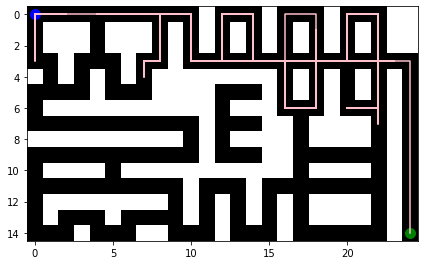

In [33]:
from Visualizer import Visualizer

easy_maze = Maze.create_maze("./../data/easy_maze.txt")
# path_spec = PathSpecification.read_coordinates("./../data/easy_solution.txt")

Visualizer.visualize_individual_path(easy_maze, shortest_route, spec)

### 2.4 Upgrading Your Ants with Intelligence

#### Question 15

In [14]:
# # Class that represents the intelligent Ant
class IntelligentAnt:

    """
    Constructor of an IntelligentAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.visited = np.zeros((maze.width, maze.length))
        self.opposite_direction = None
        self.rand = random
        self.backtracking = False

    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        route = Route(self.start)
        while self.current_position != self.end:
            next_direction = self.choose_next_direction(self.current_position)
            if self.backtracking:
                if(route.size() == 0):
                    self.visited = np.zeros((maze.width, maze.length))
                    #chosen_direction = self.rand.choice(possible_directions)
                    next_position = self.start
                    self.backtracking = False
                else:
                    last_direction = route.remove_last()
                    next_position = self.current_position.subtract_direction(last_direction)
                    self.visited[self.current_position.x][self.current_position.y] = 1
                    self.current_position = next_position
            else:
                next_position = self.current_position.add_direction(next_direction)
                route.add(next_direction)
                self.visited[self.current_position.x][self.current_position.y] = 1
                self.current_position = next_position

        #self.printVisited(self.visited)
        return route

    def printVisited(self, matrix):
        # Define colors for each value
        colors = {-1: 'red', 0: 'white', 1: 'blue'}
        
        # Calculate figure size based on matrix dimensions
        fig = plt.figure(figsize=(matrix.shape[1], matrix.shape[0]))
        
        # Create a checkerboard plot
        plt.imshow(matrix, cmap='gray', vmin=-1, vmax=1)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                plt.text(j, i, str(matrix[i, j]), ha='center', va='center', color=colors[matrix[i, j]])
        
        plt.xticks([])
        plt.yticks([])
        plt.title("Checkerboard Visualization")
        plt.show()

    def save_opposite_direction(self, direction):
        if direction == Direction.north:
            self.opposite_direction = Direction.south
            return
        if direction == Direction.east:
            self.opposite_direction = Direction.west
            return
        if direction == Direction.south:
            self.opposite_direction = Direction.north
            return
        if direction == Direction.west:
            self.opposite_direction = Direction.east
            return

    def get_possible_directions(self, position):
        possible_directions = []
        # Directions to check (all except the one the ant just came from)
        all_dir = [Direction.north, Direction.east, Direction.south, Direction.west]
        directions_to_check = []
        for dir in all_dir:
            if dir != self.opposite_direction:
                directions_to_check.append(dir)
                
        # Get the available directions based on the maze layout and bounds
        for direction in directions_to_check:
            next_position = position.add_direction(direction)
            # Check if next_position is within the bounds of the maze and contains a 1
            if self.maze.in_bounds(next_position):
                if self.maze.walls[next_position.get_x()][next_position.get_y()] == 1:
                    # If available, add to possible directions
                    possible_directions.append(direction)

        return possible_directions
    
    def choose_next_direction(self, position):
        possible_directions = self.get_possible_directions(position)
        #print(position)
        # print(self.start)
        # Filter out directions that lead to visited nodes
        unvisited_directions = []
        for dir in possible_directions:
            new_pos = position.add_direction(dir)
            if self.visited[new_pos.get_x()][new_pos.get_y()] == 0:
                unvisited_directions.append(dir)
        # unvisited_directions = [dir for dir in possible_directions if self.visited[position.add_direction(dir).get_x()][position.add_direction(dir).get_y()] == 0]

        # Pheromones
        surrounding_pheromone = self.maze.get_surrounding_pheromone(position)
        total_pheromone = surrounding_pheromone.get_total_surrounding_pheromone()
        epsilon = 10e-7 # To avoid 

        
        
        if len(unvisited_directions) > 0:
            #print("hello 1")
            #print(unvisited_directions)
            # Choose (based on pheromones) from unvisited directions
            if total_pheromone == 0:
                chosen_direction = self.rand.choice(unvisited_directions)
            else:
                probabilities = [surrounding_pheromone.get(direction) / total_pheromone + epsilon for direction in unvisited_directions]
                chosen_direction = self.rand.choices(unvisited_directions, probabilities)[0]
            self.backtracking = False  # Reset backtracking flag, we have found an unvisited path
        elif len(possible_directions) == 0:
            #print("hello 2")
            # Found dead-end, backtrack!
            chosen_direction = self.opposite_direction
            self.backtracking = True # Start backtracking (eliminating last element from route at each step)
        elif len(possible_directions) == 1:
            if position == self.start:
                #print("hello 6")
                #print(possible_directions)
                self.visited = np.zeros((maze.width, maze.length))
                chosen_direction = self.rand.choice(possible_directions)
                self.backtracking = False
            else:
                #print("hello 3", possible_directions[0])
                #print(possible_directions)
                # Still in a dead-end, continue backtracking
                self.backtracking = True
                chosen_direction = possible_directions[0]
            
        else:
            # # Choose (based on pheromones) from all possible directions, even though all are visited
            # if total_pheromone == 0:
            #     chosen_direction = self.rand.choice(possible_directions)
            # else:
            #     probabilities = [surrounding_pheromone.get(direction) / total_pheromone + epsilon for direction in possible_directions]
            #     chosen_direction = self.rand.choices(possible_directions, probabilities)[0]
            # self.backtracking = False  # Reset backtracking flag, we found an intersection!
            if position == self.start:
                #print("hello 4")
                #print(possible_directions)
                self.visited = np.zeros((maze.width, maze.length))
                chosen_direction = self.rand.choice(possible_directions)
                self.backtracking = False
            else:
                #print("hello 5")
                #print(possible_directions)
                self.backtracking = True
                chosen_direction = self.opposite_direction
                #print("chosen direction ", chosen_direction)

        # Save the opposite direction for backtracking
        self.save_opposite_direction(chosen_direction)
        return chosen_direction
    def reset_maze():
        self.visited = np.zeros((maze.width, maze.length))
        chosen_direction = self.rand.choice(possible_directions)
        self.backtracking = False
    
    def is_visited(self, position):
        return self.visited[position.get_x()][position.get_y()] != 0
    
    def mark_visited(self, position):
        self.visited[position.get_x()][position.get_y()] = 1

In [15]:
# Class representing the complete ACO algorithm.
# Finds shortest path between two points in a maze according to a path specification.
class AntColonyOptimizationIntelligent:

    """
    Constructs a new optimization object using the ant algorithm
    @param maze: the maze (environment) for ants
    @param ants_per_gen: the number of ants per generation (between update of pheromones)
    @param generations: the total number of generations of ants (pheromone updates)
    @param q: the normalization factor for the amount of dropped pheromone
    @param evaporation: the evaporation factor for the pheromones
    """
    def __init__(self, maze, ants_per_gen, generations, q, evaporation):
        self.maze = maze
        self.ants_per_gen = ants_per_gen
        self.generations = generations
        self.q = q
        self.evaporation = evaporation

    """
    Loop that starts the shortest path process
    @param path_specification: description of the route we wish to optimize
    @return the optimized route according to the ACO algorithm
    """

    def find_shortest_route(self, path_specification):
        self.maze.reset()
        shortest_route = None
        gen_counter = 0
        for gen in range(self.generations):
            gen_counter += 1
            print("Current Gen: ", gen_counter)
            routes = []
            for _ in range(self.ants_per_gen):
                ant = IntelligentAnt(self.maze, path_specification)
                route = ant.find_route()
                routes.append(route)

                # Check if this route is the shortest so far
                if shortest_route is None or route.size() < shortest_route.size():
                    shortest_route = route

            # Add pheromones for all routes found in this generation
            route_length = shortest_route.size()
            if(route_length == 0):
                route_length = 1 # avoid division by zero
            self.maze.add_pheromone_routes(routes, self.q/route_length)

            # Evaporate pheromones
            self.maze.evaporate(self.evaporation)
            

        return shortest_route

In [36]:
# Please keep your parameters for the ACO easily changeable here
ants_per_gen = 10
no_gen = 40
q = 1600
evap = 0.2

# Construct the optimization objects
maze = Maze.create_maze("./../data/hard_maze.txt")
spec = PathSpecification.read_coordinates("./../data/hard_coordinates.txt")
aco = AntColonyOptimizationIntelligent(maze, ants_per_gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/hard_solution.txt")

Ready reading maze file ./../data/hard_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  36
Current Gen:  37
Current Gen:  38
Current Gen:  39
Current Gen:  40
Time taken: 297.415
Route size: 935


In [37]:
# Please keep your parameters for the ACO easily changeable here
ants_per_gen = 1
no_gen = 5
q = 1600
evap = 0.1

# Construct the optimization objects
maze = Maze.create_maze("./../data/medium_maze.txt")
spec = PathSpecification.read_coordinates("./../data/medium_coordinates.txt")
aco = AntColonyOptimizationIntelligent(maze, ants_per_gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/medium_solution.txt")

Ready reading maze file ./../data/medium_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Time taken: 1.24
Route size: 237


Ready reading maze file ./../data/hard_maze.txt


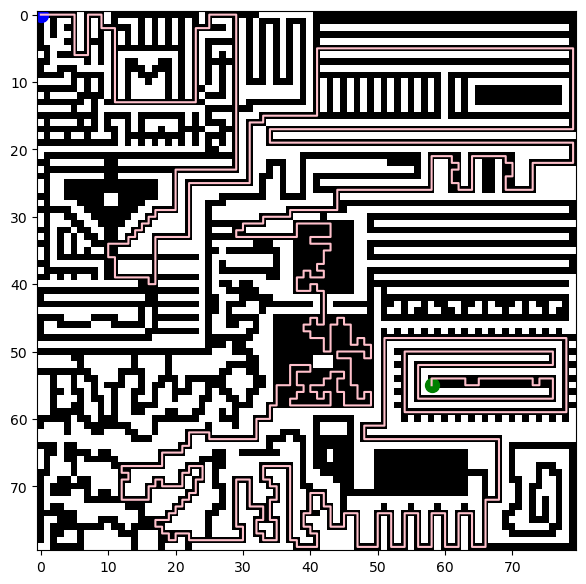

In [534]:
easy_maze = Maze.create_maze("./../data/hard_maze.txt")
# path_spec = PathSpecification.read_coordinates("./../data/easy_solution.txt")

Visualizer.visualize_individual_path(easy_maze, shortest_route, spec)

<div style="background-color:#f1be3e">

#### First optimization
One problem we have had is that an ant would visit the same nodes over and over again, getting stuck in a loop for a while. This would greatly increase the length of the path and the computation time, giving us poor results.

We decided to solve this by introducing a "visited" array, so that the ants could prioritize paths that were unexplored during that iteration.

This improvement greatly increases the chance of finding the end earlier in the algorithm, thus improving the time it takes to solve the maze.

#### Second optimization
Another problem we had is that the ants would leave pheromones also in the dead-ends of the maze, which would make other ants go in those places as well. This leads to multiple ants choosing to also explore dead-ends, which in return gives a worse performance - the paths get longer, there is no benefit to adding dead-ends in the final chosen path.

We decided to solve this problem by implementing some backtracking logic, which says that once we reach a certain point (dead-end), we go back from the same path we came from, until we find another available position (an unvisited position), while removing the "dead-end path" from the Route we have instantiated. This way, pheromones will not be added to paths that lead to dead-ends after the current iteration.

The backtracking is activated in two cases during the ACO algorithm:
- When the ant finds a dead-end: all directions other than the one we came from, point to a wall.
- When the ant is surrounded by visited nodes (still a dead-end but instead of walls, there are visited nodes).

This helps the algorithm add pheromones just to the actual, direct path taken by the current ant, thus leading to a faster convergence and a better path.

### 2.5 Parameter Optimization

#### Question 16

In [16]:
easy_maze = Maze.create_maze("./../data/easy_maze.txt")
easy_spec = PathSpecification.read_coordinates("./../data/easy_coordinates.txt")

medium_maze = Maze.create_maze("./../data/medium_maze.txt")
medium_spec = PathSpecification.read_coordinates("./../data/medium_coordinates.txt")

hard_maze = Maze.create_maze("./../data/hard_maze.txt")
hard_spec = PathSpecification.read_coordinates("./../data/hard_coordinates.txt")

Ready reading maze file ./../data/easy_maze.txt
Ready reading maze file ./../data/medium_maze.txt
Ready reading maze file ./../data/hard_maze.txt


In [16]:
def test_hyperparams(maze, spec):
    no_gens = [10, 25, 40]
    ants_per_gen_values = [10, 20, 30]
    q_values = [1000, 1600, 2000]
    evap_values = [0.1, 0.2]
    
    # Results storage
    shortest_routes = []
    convergence_times = []
    results = []
    
    # Loop over all combinations of hyperparameters
    for ants_per_gen in ants_per_gen_values:
        for q in q_values:
            for evap in evap_values:
                for no_gen in no_gens:
                    # Construct the optimization object with current hyperparameters
                    aco = AntColonyOptimizationIntelligent(maze, ants_per_gen, no_gen, q, evap)
                    
                    # Measure the time taken to find the shortest route
                    start_time = int(round(time.time() * 1000))
                    shortest_route = aco.find_shortest_route(spec)
                    end_time = int(round(time.time() * 1000))
        
                    # Record the results
                    time_taken = (end_time - start_time) / 1000.0
                    route_size = shortest_route.size()
                    convergence_times.append(time_taken)
                    shortest_routes.append(route_size)
                    results.append((ants_per_gen, q, evap, no_gen, time_taken, route_size))

    return results

In [17]:
def plot_hyperparams_grid(results, diff):
    # Plot the results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].set_title(f"Convergence Time vs. Hyperparameters - {diff} Maze")
    ax[0].set_xlabel("Hyperparameters Combination")
    ax[0].set_ylabel("Convergence Time (seconds)")
    
    ax[1].set_title(f"Shortest Route Size vs. Hyperparameters - {diff} Maze")
    ax[1].set_xlabel("Hyperparameters Combination")
    ax[1].set_ylabel("Shortest Route Size")
    
    # Prepare data for plotting
    hyperparameters_combinations = []
    convergence_times = []
    route_sizes = []
    
    for i, (ants_per_gen, q, evap, no_gen, convergence_time, route_size) in enumerate(results):
        hyperparameters_combinations.append(f"{ants_per_gen}-{q}-{evap}-{no_gen}")
        convergence_times.append(convergence_time)
        route_sizes.append(route_size)

    # Plot convergence time
    ax[0].bar(hyperparameters_combinations, convergence_times, color='skyblue')
    
    # Plot shortest route size
    ax[1].bar(hyperparameters_combinations, route_sizes, color='lightgreen')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

In [18]:
def average_best_hyperparams(hyperparams, maze, spec):
    results = []
    
    for p in hyperparams:
        time_taken = p[4]
        route_size = p[5]
        for i in range(2):
            # Construct the optimization object with current hyperparameters
            aco = AntColonyOptimizationIntelligent(maze, p[0], p[3], p[1], p[2])
            
            # Measure the time taken to find the shortest route
            start_time = int(round(time.time() * 1000))
            shortest_route = aco.find_shortest_route(spec)
            end_time = int(round(time.time() * 1000))
        
            # Record the results
            time_taken += (end_time - start_time) / 1000.0
            route_size += shortest_route.size()

        time_taken = time_taken / 3.0
        route_size = route_size / 3.0
        results.append((p[0], p[1], p[2], p[3], time_taken, route_size))

    return results

In [42]:
results_easy = test_hyperparams(maze=easy_maze, spec=easy_spec)
sorted_results_easy = sorted(results_easy, key=lambda x: (x[5], x[4]))

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current

Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  36
Current Gen:  37
Current Gen:  38
Current Gen:  39
Current Gen:  40
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18

Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  

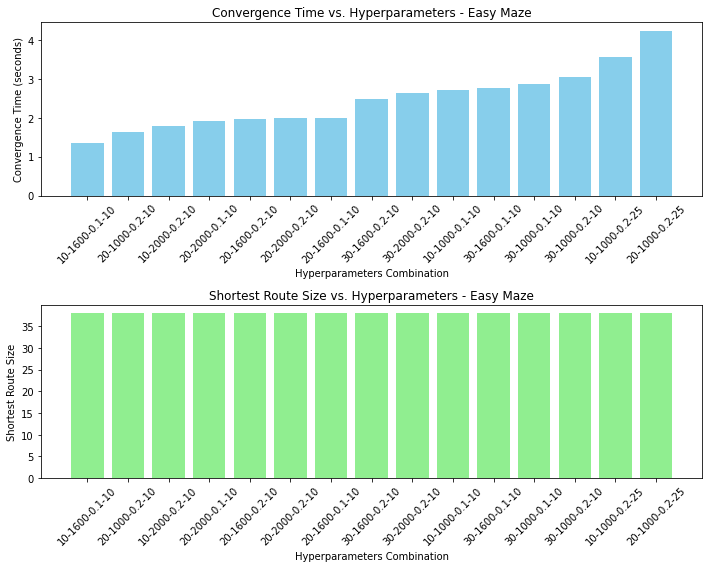

ants_per_gen=10  q=1600  evap=0.1  no_gen=10  time=1.345  route_size=38
ants_per_gen=20  q=1000  evap=0.2  no_gen=10  time=1.634  route_size=38
ants_per_gen=10  q=2000  evap=0.2  no_gen=10  time=1.793  route_size=38
ants_per_gen=20  q=2000  evap=0.1  no_gen=10  time=1.923  route_size=38
ants_per_gen=20  q=1600  evap=0.2  no_gen=10  time=1.959  route_size=38
ants_per_gen=20  q=2000  evap=0.2  no_gen=10  time=1.993  route_size=38
ants_per_gen=20  q=1600  evap=0.1  no_gen=10  time=2.002  route_size=38
ants_per_gen=30  q=1600  evap=0.2  no_gen=10  time=2.485  route_size=38
ants_per_gen=30  q=2000  evap=0.2  no_gen=10  time=2.644  route_size=38
ants_per_gen=10  q=1000  evap=0.1  no_gen=10  time=2.724  route_size=38
ants_per_gen=30  q=1600  evap=0.1  no_gen=10  time=2.774  route_size=38
ants_per_gen=30  q=1000  evap=0.1  no_gen=10  time=2.859  route_size=38
ants_per_gen=30  q=1000  evap=0.2  no_gen=10  time=3.036  route_size=38
ants_per_gen=10  q=1000  evap=0.2  no_gen=25  time=3.573  route_

In [43]:
# Visualize the 15 best results
plot_hyperparams_grid(sorted_results_easy[:15], "Easy")

# Print the 15 best results sorted by route size and convergence time
for comb in sorted_results_easy[:15]:
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

In [44]:
# Take the 5 best results, retry each of them twice, average them and see which one is the best
final_results_easy = average_best_hyperparams(sorted_results_easy[:5], easy_maze, easy_spec)
print("Best averaged - Easy Maze:")
for comb in sorted(final_results_easy, key=lambda x: (x[5], x[4])):
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Cu

In [52]:
results_medium = test_hyperparams(maze=medium_maze, spec=medium_spec)
sorted_results_medium = sorted(results_medium, key=lambda x: (x[5], x[4]))

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current

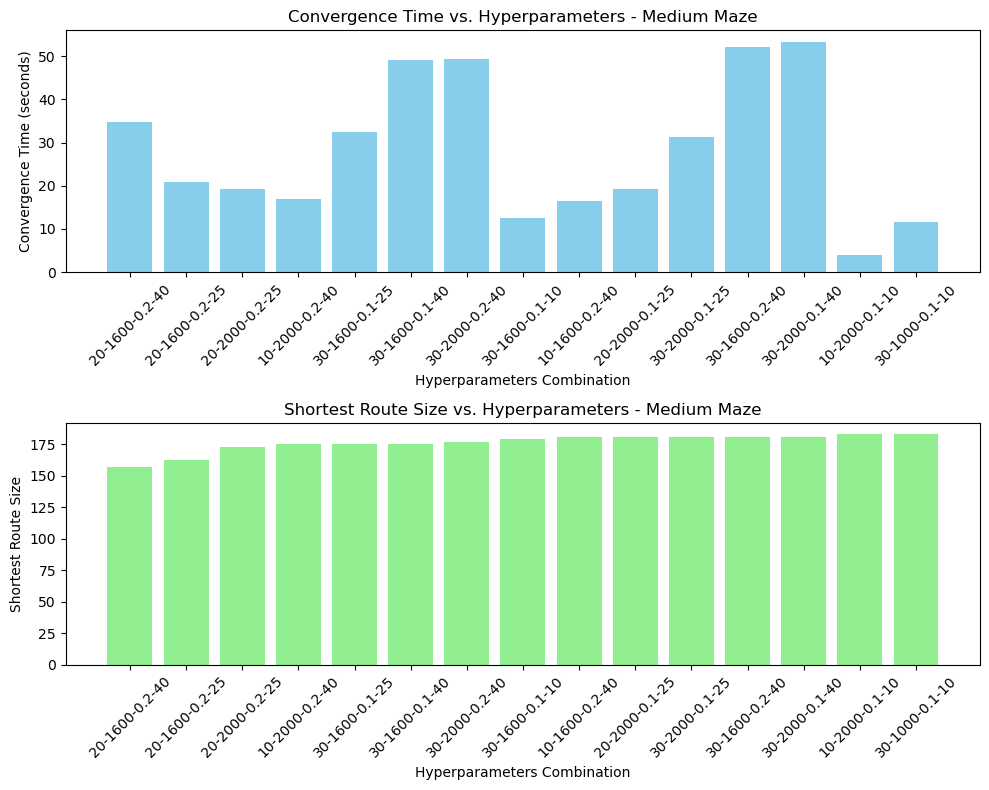

ants_per_gen=20  q=1600  evap=0.2  no_gen=40  time=34.785  route_size=157
ants_per_gen=20  q=1600  evap=0.2  no_gen=25  time=20.905  route_size=163
ants_per_gen=20  q=2000  evap=0.2  no_gen=25  time=19.3  route_size=173
ants_per_gen=10  q=2000  evap=0.2  no_gen=40  time=16.881  route_size=175
ants_per_gen=30  q=1600  evap=0.1  no_gen=25  time=32.344  route_size=175
ants_per_gen=30  q=1600  evap=0.1  no_gen=40  time=49.164  route_size=175
ants_per_gen=30  q=2000  evap=0.2  no_gen=40  time=49.299  route_size=177
ants_per_gen=30  q=1600  evap=0.1  no_gen=10  time=12.457  route_size=179
ants_per_gen=10  q=1600  evap=0.2  no_gen=40  time=16.591  route_size=181
ants_per_gen=20  q=2000  evap=0.1  no_gen=25  time=19.325  route_size=181
ants_per_gen=30  q=2000  evap=0.1  no_gen=25  time=31.214  route_size=181
ants_per_gen=30  q=1600  evap=0.2  no_gen=40  time=52.252  route_size=181
ants_per_gen=30  q=2000  evap=0.1  no_gen=40  time=53.341  route_size=181
ants_per_gen=10  q=2000  evap=0.1  no_ge

In [53]:
# Visualize the 15 best results
plot_hyperparams_grid(sorted_results_medium[:15], "Medium")

# Print the 15 best results in order of how good they are
for comb in sorted_results_medium[:15]:
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

In [55]:
# Take the 5 best results, retry each of them twice, average them and see which one is the best
final_results_medium = average_best_hyperparams(sorted_results_medium[:5], medium_maze, medium_spec)
print("Best averaged - Medium Maze:")
for comb in sorted(final_results_medium, key=lambda x: (x[5], x[4])):
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  36
Current Gen:  37
Current Gen:  38
Current Gen:  39
Current Gen:  40
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  2

In [56]:
results_hard = test_hyperparams(maze=hard_maze, spec=hard_spec)
sorted_results_hard = sorted(results_hard, key=lambda x: (x[5], x[4]))

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current

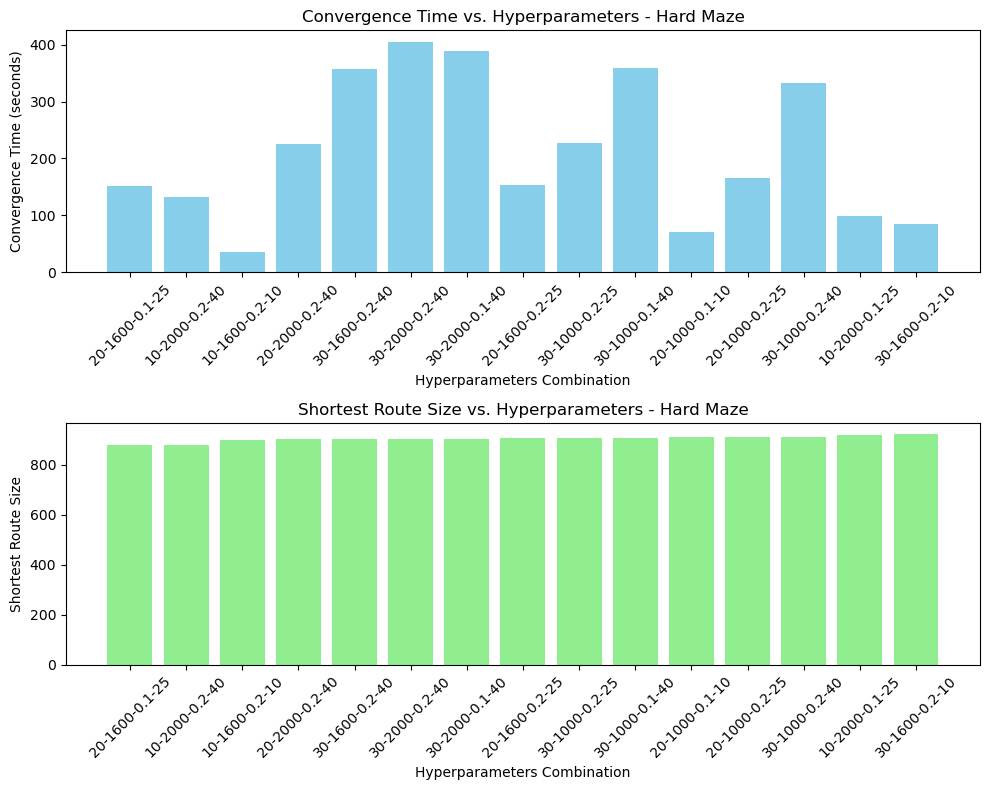

ants_per_gen=20  q=1600  evap=0.1  no_gen=25  time=151.747  route_size=877
ants_per_gen=10  q=2000  evap=0.2  no_gen=40  time=132.659  route_size=879
ants_per_gen=10  q=1600  evap=0.2  no_gen=10  time=34.595  route_size=899
ants_per_gen=20  q=2000  evap=0.2  no_gen=40  time=225.962  route_size=901
ants_per_gen=30  q=1600  evap=0.2  no_gen=40  time=357.197  route_size=901
ants_per_gen=30  q=2000  evap=0.2  no_gen=40  time=405.287  route_size=901
ants_per_gen=30  q=2000  evap=0.1  no_gen=40  time=388.401  route_size=903
ants_per_gen=20  q=1600  evap=0.2  no_gen=25  time=152.785  route_size=905
ants_per_gen=30  q=1000  evap=0.2  no_gen=25  time=227.821  route_size=905
ants_per_gen=30  q=1000  evap=0.1  no_gen=40  time=358.606  route_size=905
ants_per_gen=20  q=1000  evap=0.1  no_gen=10  time=70.555  route_size=911
ants_per_gen=20  q=1000  evap=0.2  no_gen=25  time=164.834  route_size=911
ants_per_gen=30  q=1000  evap=0.2  no_gen=40  time=332.83  route_size=911
ants_per_gen=10  q=2000  eva

In [57]:
# Visualize the 15 best results
plot_hyperparams_grid(sorted_results_hard[:15], "Hard")

# Print the 15 best results results in order of how good they are
for comb in sorted_results_hard[:15]:
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

In [59]:
# Take the 5 best results, retry each of them twice, average them and see which one is the best
final_results_hard = average_best_hyperparams(sorted_results_hard[:5], hard_maze, hard_spec)
print("Best averaged - Hard Maze:")
for comb in sorted(final_results_hard, key=lambda x: (x[5], x[4])):
    print(f"ants_per_gen={comb[0]}  q={comb[1]}  evap={comb[2]}  no_gen={comb[3]}  time={comb[4]}  route_size={comb[5]}")

Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current

<div style="background-color:#f1be3e">

We tested different values for the following hyperparameters:
- ants_per_gen: Number of ants per generation that need to find a path
- no_gens: Number of generations
- q: Constant used in the calculation of the pheromone update
- evap: Evaporation rate

We consider the "best" combination of hyperparameters the one that gives the best shortest_route_size and also a fairly short convergence time. So we sort firstly based on route_size, and then on time.

We made some helper functions to help us with this question:
- test_hyperparams: It runs the ACO algorithm with different combinations of hyperparameter values (grid search)
- plot_hyperparams_grid: Visualizes the results of the grid search by plotting the convergence time and shortest route size, for different combinations of hyperparameters.
- average_best_hyperparams: Refines the evaluation of the best-performing 5 hyperparameter combinations by averaging the results of multiple runs.

The values of the hyperparameters that are tested are the following:
- ants_per_gen: [10, 20, 30] 
- no_gens: Number of generations: [10, 25, 40]
- q: Constant used in the calculation of the pheromone update: [1000, 1600, 2000]
- evap: Evaporation rate: [0.1, 0.2]

Disclaimer: We are aware that larger number of ants_per_gen and no_gens could possibly lead to better results (not a fact, just an assumption - in particular for the hard maze), but for the sake of the high convergence time, we will omit testing it with larger values.

We can see from the output cells above, that the final Averaged Results for each maze are printed in increasing order of firstly route_size, and secondly convergence time. The first row that is printed for each maze, under "Best Averaged Results" is the best combination of hyperparameters we have found for that specific maze, from all the combinations that we tried. There may exist other better ones, with completely different parameters, but we consider these results to be good enough for the purpose of the assignment and we will continue with them.

The results were the following:
- Easy Maze: no_gen=10, ants_per_gen=10, q=1600, evap=0.1 
- Medium Maze: no_gen=40, ants_per_gen=20,  q=1600,  evap=0.2
- Hard Maze: no_gen=40, ants_per_gen=30, q=1600, evap=0.2

#### Question 17

<div style="background-color:#f1be3e">

As the mazes get larger and more complex:
1. no_gen: The "optimal" number of generations increases, as more generations are needed to explore the maze thoroughly and potentially find a more optimal path.
2. ants_per_gen: Similarly with the number of generations, the optimal number of ants per generation also increases. More ants are required to cover larger areas of the maze and increase the chances of finding the shortest path.
3. q: The optimal value of the pheromone update constant might vary. In general, a higher value of q encourages stronger pheromone updates, which can help guide ants towards more promising pahts. However, overly high values may lead to premature convergence or inefficient exploration.
4. evap: In harder mazes, where exploration is crucial, a higher evaporation rate might be beneficial since the rapid dissipation of pheromones may encourage ants to explore alternative paths more extensively, preventing them from getting stuck in suboptimal routes. Alternatively, in easier mazes, where straightforward paths are more prevalent, a lower evaporation rate might be sufficient to preserve the pheromone trails.
5. convergence time: It tends to increase with maze complexity and size, due to the increased search space and potential dead ends or complex pathways that need to be explored. However, the optimization of the other hyperparameters can help mitigate this increase to some extent.

### 2.6 The Final Route

#### Question 18

Ready reading maze file ./../data/easy_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Time taken: 1.044
Route size: 38


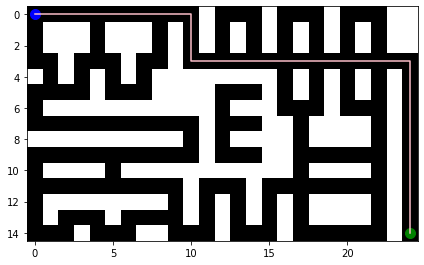

In [19]:
# Easy Maze
maze = Maze.create_maze("./../data/easy_maze.txt")
spec = PathSpecification.read_coordinates("./../data/easy_coordinates.txt")
aco = AntColonyOptimizationIntelligent(maze, 10, 10, 1600, 0.1)

start_time = int(round(time.time() * 1000))
easy_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(easy_route.size()))

easy_route.write_to_file("./../data/25_easy.txt")

Visualizer.visualize_individual_path(maze, easy_route, spec)

Ready reading maze file ./../data/medium_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  36
Current Gen:  37
Current Gen:  38
Current Gen:  39
Current Gen:  40
Time taken: 170.87
Route size: 179


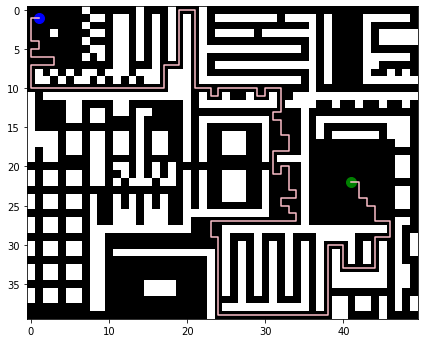

In [20]:
# Medium Maze
maze = Maze.create_maze("./../data/medium_maze.txt")
spec = PathSpecification.read_coordinates("./../data/medium_coordinates.txt")
aco = AntColonyOptimizationIntelligent(maze, 20, 40, 1600, 0.2)

start_time = int(round(time.time() * 1000))
medium_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(medium_route.size()))

medium_route.write_to_file("./../data/25_medium.txt")

Visualizer.visualize_individual_path(maze, medium_route, spec)

Ready reading maze file ./../data/hard_maze.txt
Current Gen:  1
Current Gen:  2
Current Gen:  3
Current Gen:  4
Current Gen:  5
Current Gen:  6
Current Gen:  7
Current Gen:  8
Current Gen:  9
Current Gen:  10
Current Gen:  11
Current Gen:  12
Current Gen:  13
Current Gen:  14
Current Gen:  15
Current Gen:  16
Current Gen:  17
Current Gen:  18
Current Gen:  19
Current Gen:  20
Current Gen:  21
Current Gen:  22
Current Gen:  23
Current Gen:  24
Current Gen:  25
Current Gen:  26
Current Gen:  27
Current Gen:  28
Current Gen:  29
Current Gen:  30
Current Gen:  31
Current Gen:  32
Current Gen:  33
Current Gen:  34
Current Gen:  35
Current Gen:  36
Current Gen:  37
Current Gen:  38
Current Gen:  39
Current Gen:  40
Time taken: 1407.377
Route size: 951


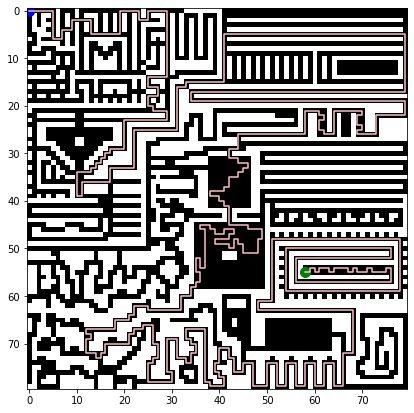

In [21]:
# Hard Maze
maze = Maze.create_maze("./../data/hard_maze.txt")
spec = PathSpecification.read_coordinates("./../data/hard_coordinates.txt")
aco = AntColonyOptimizationIntelligent(maze, 30, 40, 1600, 0.2)

start_time = int(round(time.time() * 1000))
hard_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(hard_route.size()))

hard_route.write_to_file("./../data/25_hard.txt")

Visualizer.visualize_individual_path(maze, hard_route, spec)

In [20]:
# Print the contents of the files
with open('../data/25_easy.txt', 'r') as file:
    # Read the contents of the file
    file_contents = file.read()
    # Print the contents
    print("Easy Maze:")
    print(file_contents)

print()
with open('../data/25_medium.txt', 'r') as file:
    # Read the contents of the file
    file_contents = file.read()
    # Print the contents
    print("Medium Maze:")
    print(file_contents)

print()
with open('../data/25_hard.txt', 'r') as file:
    # Read the contents of the file
    file_contents = file.read()
    # Print the contents
    print("Hard Maze:")
    print(file_contents)

Easy Maze:
38;
0, 0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
3;
3;
3;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;


Medium Maze:
179;
1, 1;
2;
3;
3;
3;
0;
3;
2;
3;
0;
0;
0;
3;
2;
2;
2;
3;
3;
3;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
1;
1;
1;
0;
0;
1;
1;
1;
1;
1;
1;
1;
0;
0;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
0;
0;
3;
0;
1;
0;
0;
0;
0;
0;
3;
0;
1;
0;
0;
3;
3;
3;
2;
3;
0;
3;
3;
0;
3;
3;
2;
2;
3;
3;
3;
0;
1;
0;
3;
3;
3;
0;
3;
2;
2;
3;
0;
3;
0;
3;
2;
2;
2;
2;
2;
2;
2;
2;
2;
2;
2;
3;
3;
0;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
0;
1;
1;
1;
1;
1;
1;
1;
1;
1;
0;
0;
3;
3;
3;
0;
0;
0;
0;
1;
1;
1;
1;
0;
0;
1;
1;
2;
2;
1;
1;
2;
1;
2;
1;
1;
2;


Hard Maze:
951;
0, 0;
0;
0;
0;
0;
0;
3;
3;
3;
3;
3;
3;
0;
0;
1;
1;
0;
0;
1;
1;
0;
0;
0;
0;
3;
3;
3;
0;
0;
0;
0;
0;
0;
1;
1;
1;
1;
1;
0;
0;
0;
0;
3;
3;
0;
0;
1;
1;
0;
0;
0;
0;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
3;
2;
2;
2;
2;
3;
3;
0;
0;
3;
3;
2;
2;
3;
3;
0;
3;
0;
0;
0;
3;
3;
2;
2;
2;
2;
2;
2;
2;

<div style="background-color:#f1be3e">

In the code blocks above we ran the optimal hyperparameters found in the previous questions, and considering the "randomness" of the algorithm, we still found good paths. For the medium and hard mazes, there are undoubtedly better solutions, but since the range of our hyperparameter value testing wasn't very extensive (for the sake of computation time we had a maximum of 40 generations, and a maximum of 30 ants per generation, for example) the results make sense and seem fairly good!

The solutions in the required format are saved in the files:
- 25_easy.txt
- 25_medium.txt
- 25_hard.txt

These solutions are also printed in the cell above, to show that they are indeed saved in the correct format.

### 2.7 Synthesis

#### Question 19

In [ ]:
# This cell takes a long time to run
# Please skip this if you decide to rerun the whole notebook
# We have the results saved in the file "my_tsp2"

gen = 30
no_gen = 10
q = 1600
evap = 0.2

persist_file = "./../data/my_tsp2"
tsp_path = "./../data/tsp_products.txt"
coordinates = "./../data/hard_coordinates.txt"

# Construct optimization
maze = Maze.create_maze("./../data/hard_maze.txt")
tsp_data = TSPData.read_specification(coordinates, tsp_path)
print(tsp_data)
aco = AntColonyOptimizationIntelligent(maze, gen, no_gen, q, evap)

# # Run optimization and write to file
# tsp_data.calculate_routes(aco)
# tsp_data.write_to_file(persist_file)

In [14]:
population_size = 64
cross_over_prob = 0.4
mutation_prob = 0.6
exponential_scaling = 1
elite_percent = 0.1
cross_over_summing = True

generations = 3000
fitness_threshold = 1343
persist_file = "../data/my_tsp2"

# Setup optimization
tsp_data = TSPData.read_from_file(persist_file)
ga = GeneticAlgorithm(generations, population_size, cross_over_prob, mutation_prob, exponential_scaling, elite_percent, fitness_threshold, cross_over_summing)

# Run optimzation and write to file
solution = ga.solve_tsp(tsp_data)
tsp_data.write_action_file(solution, "../data/25_actions_TSP.txt")

Selected Path: [0, 1, 6, 4, 13, 15, 3, 8, 17, 7, 9, 14, 11, 12, 5, 10, 2, 16]


<div style="background-color:#f1be3e">

Disclaimer: 
- Calculating the routes for the ACO with the products from my_tsp2.txt takes a very long time (we had to run it overnight). For this reason, we decided to decrease the number of generations down to 10. This will evidently give a poorer result, but using the optimal number of generations we found (40), would have taken 4 times longer. We decided to trade the "minimal" possible result (path size between different objects), for the sake of computation time, which we consider is a trade-off that is appliccable in many situations in the world of data.
- If for some reason the notebook needs to be rerun, the route calculation between products and start/end points needs to be skipped since it will take way too long. We have the saved results from the ACO algorithm in the file "my_tsp2", so we will use those ones to solve TSP.


The order of the items is identical, which speaks the the fact that the distances between the items was calculated very well.
If the distances had been different from optimal_tsp then we would expect the order to change too.
The total distance of the path from our own tsp file is 1397. This is very close to the 1343 we achieved with optimal_tsp.
Optimal tsp is slightly better, because on longer stretches of maze with an open area, it goes perfectly straight and directly to the item, meanwhile our ants sometimes meander a little bit and add a few unnecessary steps along the way. 

One thing that also affects the total distance of the optimal path found using the output of the ACO algorithm is that we chose to have only 10 generations, instead of the optimal value that we found in the hyperparameter tuning (which was 40), due to the long time it took to run.

## Part 3: Open Questions
### 3.1 Reflection

#### Question 20

<div style="background-color:#f1be3e">

One example where defining the fitness function might be difficult, is in problems where the actual result we are trying to optimize for is unclear at time of measuring, such as in chess. At the time where we make the first move, it is very difficult to measure how fit this solution was towards the goal of capturing the enemy king, which is most likely many moves away. The search space of possibilities following this move is too vast to compute all options and exhaustively find  a solution. Instead one will have to find a way of optimizing towards proxies of this end goal, such as having more pieces with higher value, keeping ones king safe, moving pawns down the board, etc. Balancing these goals in a way that conveys the actual underlying goal of capturing the enemy king is hard.

#### Question 21

<div style="background-color:#f1be3e">

One issue we ran into was that our cross over algorithm was bugged, but we didn't notice it. The result was that the ga would only slowly converge to a good solution when the mutation probability was low, but setting it high would (in comparison) find solutions very efficiently. This is also the effect that always selecting the fittest chromosomes would have. Crossing over would always results in identical or very similiar chromosomes and thus the solution space would not be explored very thoroughly. The only means of evolving would be random mutations, which essentially boils down to a bad brute force algorithm. Instead we want to select the chromosomes with good fitness with a higher likelihood than those with a bad fitness, to gradually move the population pool towards fitter solutions. However chromosomes with weaker fitness also need to have a chance of being selected, to invoke the evolutional benefits of the genetic algorithm. Perhaps a good and an ok chromosome create a great chromosome when crossed over. Using this we can explore the solution space quite widely, to get a good sense of the options at hand without computing literally every possible solution in a certain range.

At the same time we do want the strongest chromosome to survive, just not that it is selected with 100% probability for each cross over and cloning step. It clearly contains a good solution and we want to ensure that that solution is not lost, which is guaranteed through elitism.

### 3.2 Pen and Paper

#### Question 22

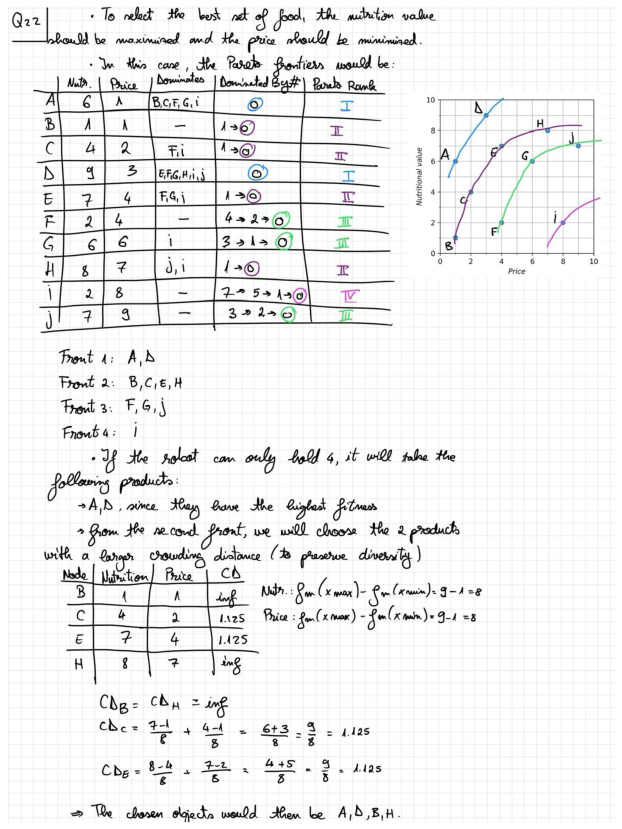

In [50]:
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
plt.imshow(mpimg.imread("../data/q22.jpg"))
plt.axis('off')
plt.show()

<!-- <div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._ -->

#### Question 23

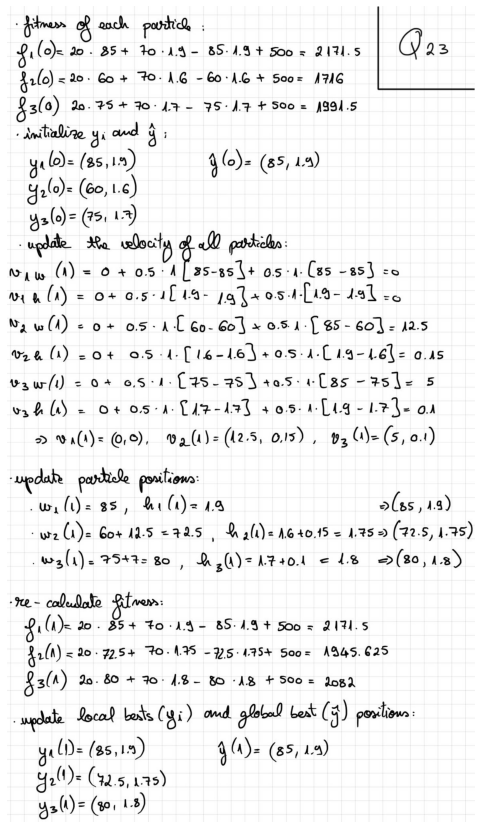

In [51]:
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
plt.imshow(mpimg.imread("../data/q23.jpg"))
plt.axis('off')
plt.show()

<!-- <div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._ -->

### 3.3 Division of Work

#### Question 24

<div style="background-color:#f1be3e">


|          Component          |  Antonio Lupu   |  Eve Smura   |  Jannes Kelso   |  Maria Cristescu   |
|-----------------------------|-----------|-----------|-----------|-----------|
| Code (design)               |     25%     |     25%     |     25%     |     25%     |
| Code (implementation)       |     25%     |     25%     |     25%     |     25%     |
| Code (validation)           |     25%     |     25%     |     25%     |     25%     |
| Experiments (execution)     |     25%     |     25%     |     25%     |     25%     |
| Experiments (analysis)      |     25%     |     25%     |     25%     |     25%     |
| Experiments (visualization) |     25%     |     25%     |     25%     |     25%     |
| Report (original draft)     |     25%     |     25%     |     25%     |     25%     |
| Report (reviewing, editing) |     25%     |     25%     |     25%     |     25%     |

### References

<div style="background-color:#f1be3e">

**If you made use of any non-course resources, cite them below.**